In [129]:
pip install spafe

In [130]:
import librosa
import numpy as np
from fastdtw import fastdtw
import matplotlib.pyplot as plt
from spafe.features.lpc import lpc

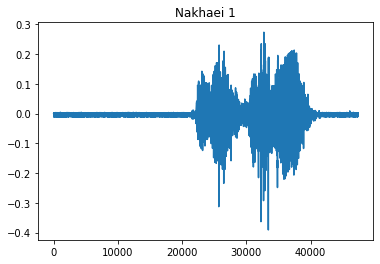

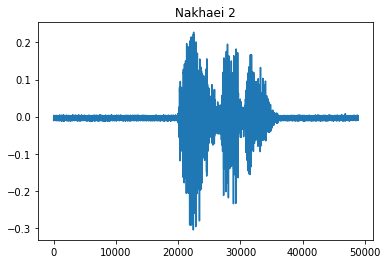

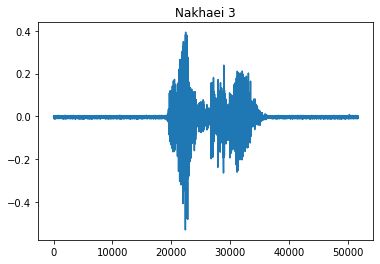

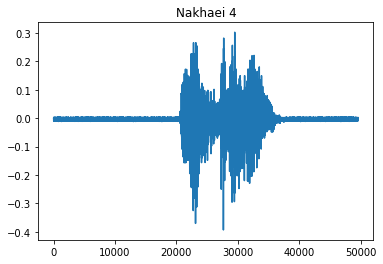

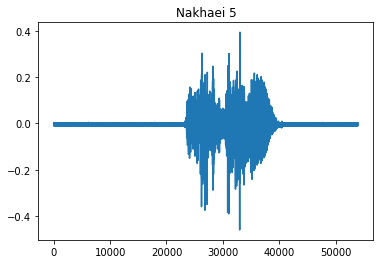

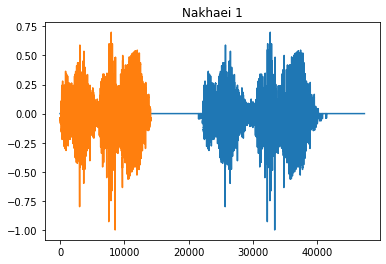

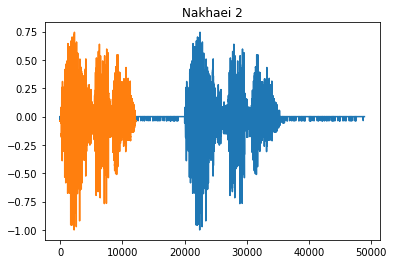

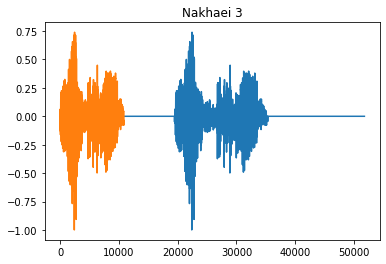

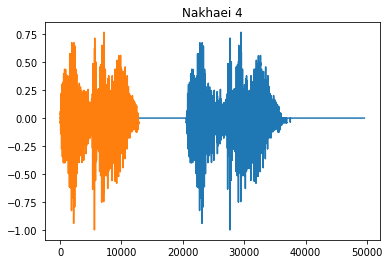

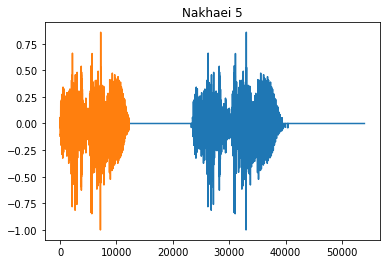

In [131]:
######################## DTW WITHOUT FEATURES ##############################################

lastname_count = 15
lastname_signals = []
figure_count = 5
def show_figure(signal,title,figure_number):
    plt.figure(figure_number)
    plt.title(title)
    plt.plot(signal)

for i in range(lastname_count):
    s, sample_rate = librosa.load("/content/Learn/Nakhaei ({}).wav".format(i+1))
    if i<figure_count:
      show_figure(s,"Nakhaei {}".format(i+1),i+1)
    lastname_signals.append(s)



def prepare_signals(signals,show=False):
    for i in range(len(signals)):
        temp = librosa.util.normalize(signals[i])
        for j in range(len(temp)):
            if abs(temp[j]) < 0.035 :
                temp[j] = 0
        if show and i<figure_count:
            show_figure(temp,"Nakhaei {}".format(i+1),figure_count+i+1)
        temp2 = []
        for data in temp:
            if abs(data) > 0.03:
                temp2.append(data)
        temp2 = np.array(temp2)
        if show and i<figure_count:
            show_figure(temp2,"Nakhaei {}".format(i+1),figure_count+i+1)
        signals[i] = temp2
    
    return signals

lastname_signals = prepare_signals(lastname_signals,True)

dtw = np.zeros((lastname_count,lastname_count))
for i in range(lastname_count):
    for j in range(lastname_count):
        dtw[i][j] , path = fastdtw(lastname_signals[i], lastname_signals[j])

In [132]:
file=open('DTW without Feature.csv','w')

for i in range(lastname_count+1):
    line = ''
    if i==0 :
        line = '/'
        for j in range(lastname_count):
            line += ',voice {}'.format(j+1)
    else :
        line = 'voice {},'.format(i) + ','.join(map(str, dtw[i-1]))
    line +='\n'
    file.write(line)
file.close()
dtw = np.array(dtw)

row_average = []
for i in range(lastname_count):
    row_average.append(np.sum(dtw[i])/(lastname_count-1))

total_average = np.average(row_average)
row_max = max(row_average)
row_min = min(row_average)
print("\nAverage = ",total_average)
print("Max = ",row_max)
print("Min = ",row_min,"\n")
for i in range(len(row_average)):
    print("Row {} Average = ".format(i+1),row_average[i])


def find_reference_signal(row_average,total_average):
    min_distance = abs(total_average - row_average[0])
    index = 0
    for i in range(len(row_average)):
        dist = abs(total_average - row_average[i])
        if dist < min_distance:
            min_distance = dist
            index = i
    return index


index = find_reference_signal(row_average,total_average)
reference_signal = lastname_signals[index]
print("Reference Signal = Last Name ({})".format(index+1))


Average =  1144.4106293422126
Max =  1413.680191164304
Min =  975.0790404781167 

Row 1 Average =  1171.870378928525
Row 2 Average =  1244.4376573536013
Row 3 Average =  1084.458995508296
Row 4 Average =  1171.3990395364485
Row 5 Average =  1086.017518190933
Row 6 Average =  1122.7233877932388
Row 7 Average =  998.5833871872829
Row 8 Average =  1327.9462599102408
Row 9 Average =  1109.994025467496
Row 10 Average =  1038.4974174185522
Row 11 Average =  1144.3467728921346
Row 12 Average =  1121.2611470507193
Row 13 Average =  1155.8642212532993
Row 14 Average =  975.0790404781167
Row 15 Average =  1413.680191164304
Reference Signal = Last Name (11)


In [133]:
##################### TEST LAST NAME (MY VOICE) #################################################

test_lastname_count = 10
test_lastname_signals = []

for i in range(test_lastname_count):
    s, sample_rate = librosa.load("/content/Test/Test Nakhaei ({}).wav".format(i+1))
    test_lastname_signals.append(s)

test_lastname_signals = prepare_signals(test_lastname_signals)

dtw_test_ln = np.zeros(test_lastname_count)
result_test_ln = []
for i in range(test_lastname_count):
    dtw_test_ln[i] , path = fastdtw(reference_signal, test_lastname_signals[i])
    if row_min <= dtw_test_ln[i] and dtw_test_ln[i] <= row_max:
        result_test_ln.append(1)
    else:
        result_test_ln.append(0)

print("Result Last Name Test = ",dtw_test_ln)
print("Recognition Result = ",result_test_ln)

Result Last Name Test =  [1267.27855448 1144.57025251 1403.42340543 1514.23642429 1204.19851447
 1360.60492796 1173.28071896 1137.65361643 1184.91024324 1370.21862067]
Recognition Result =  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1]


In [134]:
##################### TEST OTHER WORDS (NOT MY VOICE) ##########################################

test_others_count = 10
test_others_signals = []

for i in range(test_others_count):
    s, sample_rate = librosa.load("/content/Test/Test Others ({}).wav".format(i+1))
    test_others_signals.append(s)

test_others_signals = prepare_signals(test_others_signals)

dtw_test_others = np.zeros(test_others_count)
result_test_others = []
for i in range(test_others_count):
    dtw_test_others[i] , path = fastdtw(reference_signal, test_others_signals[i])
    if row_min <= dtw_test_others[i] and dtw_test_others[i] <= row_max:
        result_test_others.append(1)
    else:
        result_test_others.append(0)

print("Result Others Test = ",dtw_test_others)
print("Recognition Result = ",result_test_others)

Result Others Test =  [1747.73749425 1598.63425955 2272.89654504 1856.20648333 1664.07502133
 2929.92354551 2119.0191853  3260.0789389  3416.4742026  2315.9752529 ]
Recognition Result =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [135]:
##################### FEATURE EXTARCTION FUNCTIONS ##########################################

def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.
    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,shape=(nrows, stride_length),strides=(stride_step*n, n))
     
def framing(sig, fs=11025, win_len=0.2, win_hop=0.1):
    """
    transform a signal into a series of overlapping frames (=Frame blocking).
    Args:
        sig     (array) : a mono audio signal (Nx1) from which to compute features.
        fs        (int) : the sampling frequency of the signal we are working with.
                          Default is 16000.
        win_len (float) : window length in sec.
                          Default is 0.025.
        win_hop (float) : step between successive windows in sec.
                          Default is 0.01.

    Returns:
        array of frames.
        frame length.

    Notes:
    ------
        Uses the stride trick to accelerate the processing.
    """
    # run checks and assertions
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length

def add_feature(features,f):
    features.append(np.min(f))
    features.append(np.max(f))
    features.append(np.average(f))
    features.append(np.mean(f))
    return features

def feature_extraction(signals_frames):
    signals_features = []
    for signalframes in signals_frames:
        features=[]
        for frame in signalframes:
            ff = []
        
            # MFCC
            ff = add_feature(ff,librosa.feature.mfcc(frame,11025))
            # ZeroCrossing
            ff = add_feature(ff,
                librosa.feature.zero_crossing_rate(frame, 11025))
            # Energy
            ff = add_feature(ff,np.array([data * data for data in frame]))
            # RMS
            ff = add_feature(ff,librosa.feature.rms(frame,11025))
            # LPC
            ff = add_feature(ff,
                lpc(frame, fs=11025, num_ceps=13,  win_len=0.2, win_hop=0.1))
            
            features.append(ff)

        signals_features.append(features)
    return signals_features


In [136]:
##################### FEATURE EXTARCTION ##########################################

lastnames_frames = []

for s in lastname_signals:
    frames, length = framing(s,11025)
    lastnames_frames.append(frames)

lastnames_features = feature_extraction(lastnames_frames)

dtw_with_feature = np.zeros((lastname_count,lastname_count))
for i in range(lastname_count):
    for j in range(lastname_count):
        dtw_with_feature[i][j] , path = fastdtw(lastnames_features[i], lastnames_features[j])


file=open('DTW with Feature.csv','w')

for i in range(lastname_count+1):
    line = ''
    if i==0 :
        line = '/'
        for j in range(lastname_count):
            line += ',voice {}'.format(j+1)
    else :
        line = 'voice {},'.format(i) + ','.join(map(str, dtw_with_feature[i-1]))
    line +='\n'
    file.write(line)
file.close()
dtw_with_feature = np.array(dtw_with_feature)

row_average = []
for i in range(lastname_count):
    row_average.append(np.sum(dtw_with_feature[i])/(lastname_count-1))

total_average = np.average(row_average)
row_max = max(row_average)
row_min = min(row_average)
print("\nAverage = ",total_average)
print("Max = ",row_max)
print("Min = ",row_min,"\n")
for i in range(len(row_average)):
    print("Row {} Average = ".format(i+1),row_average[i])

index = find_reference_signal(row_average,total_average)
reference_signal = lastname_signals[index]
print("Reference Signal = LastName",index+1)


Average =  402.1326553015249
Max =  590.0947732683524
Min =  326.4468240538327 

Row 1 Average =  431.14643669603
Row 2 Average =  590.0947732683524
Row 3 Average =  385.86774086018943
Row 4 Average =  326.4468240538327
Row 5 Average =  530.4662969834266
Row 6 Average =  370.99556760636534
Row 7 Average =  480.24372466352236
Row 8 Average =  348.23456254243246
Row 9 Average =  370.01649369020146
Row 10 Average =  385.88276940553084
Row 11 Average =  346.7011030559083
Row 12 Average =  333.66307488131105
Row 13 Average =  393.1027444819906
Row 14 Average =  362.1017144436046
Row 15 Average =  377.02600289017494
Reference Signal = LastName 13


In [137]:
##################### TEST LAST NAME WITH FEATURE (MY VOICE) #################################################

test_ln_frames = []

for s in test_lastname_signals:
    frames, length = framing(s,11025)
    test_ln_frames.append(frames)

test_ln_features = feature_extraction(test_ln_frames)

dtw_test_ln_feature = np.zeros(test_lastname_count)
result_test_ln_feature = []
for i in range(test_lastname_count):
    dtw_test_ln_feature[i] , path = fastdtw(lastnames_features[index], test_ln_features[i])
    if row_min <= dtw_test_ln_feature[i] and dtw_test_ln_feature[i] <= row_max:
        result_test_ln_feature.append(1)
    else:
        result_test_ln_feature.append(0)

print("Result Last Name Feature Test = ",dtw_test_ln_feature)
print("Recognition Result = ",result_test_ln_feature)

Result Last Name Feature Test =  [350.00244533 375.81143182 435.73137398 423.11136747 488.62640057
 395.89321872 375.06995412 366.28341491 421.73251121 388.65656812]
Recognition Result =  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [138]:
##################### TEST OTHER WORDS WITH FEATURE (NOT MY VOICE) ##########################################


test_others_frames = []

for s in test_others_signals:
    frames, length = framing(s,11025)
    test_others_frames.append(frames)

test_others_features = feature_extraction(test_others_frames)

dtw_test_others_feature = np.zeros(test_others_count)
result_test_others_feature = []
for i in range(test_others_count):
    dtw_test_others_feature[i] , path = fastdtw(lastnames_features[index], test_others_features[i])
    if row_min <= dtw_test_others_feature[i] and dtw_test_others_feature[i] <= row_max:
        result_test_others_feature.append(1)
    else:
        result_test_others_feature.append(0)

print("Result Others Feature Test = ",dtw_test_others_feature)
print("Recognition Result = ",result_test_others_feature)

Result Others Feature Test =  [ 609.64178273  802.56435736 1010.56206984  686.08454729  640.75902657
  749.23625528  852.34978099  688.54621938  749.59503038  823.78872832]
Recognition Result =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
